In [1]:
"""Data analysis and processing package imports"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy


In [2]:
def csv_import(filename, header = True):
    """Imports csv file as a list and separates headers from data"""
    import csv
    file = open(filename)
    readfile = csv.reader(file)
    listfile = list(readfile)
    if header == True:
        headers = listfile[0]
        data = listfile[1:]
    else:
        data = listfile
    return headers, data

In [3]:
filename = 'CompositeData_Export.csv'
idx_data = pd.read_csv(filename)

nlandings = idx_data.index

for i in nlandings:
    if np.isnan(idx_data.loc[i,'number_of_conspecifics']) == True:
                    idx_data = idx_data.drop(i)

ntrials, columns = idx_data.shape
new_index = np.linspace(0, ntrials, ntrials, False)
new_index = np.array(new_index + 1)
new_idx = new_index.astype(int)

idx_data.set_index(new_idx, inplace=True)
idx_data['date'] = idx_data['date'].astype(str).str.strip('.0')

# idx_data['number_of_conspecifics']

In [4]:
"""Import proximity data"""
prox_data_dict = {}
for i in np.arange(ntrials):
    date = idx_data['date'].iat[i]
    vid_id = idx_data['gopro_vid_id'].iat[i]
    filename = str('GoPro_Proximity_dataset/' + date + '-digi-consp-GP.Landing.' + vid_id + '-xyzpts.csv')
    
    try:
        axes, data = csv_import(filename)
    except FileNotFoundError:
        print(filename)
    
    data = np.array(data).astype('float64')
    prox_data_dict[i] = {'raw':data}

In [5]:
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - 1)
    
    landing = prox_data_dict[i]['raw'].copy()
    num = int(idx_data['number_of_conspecifics'].iloc[i] * -1 * 3 - (2*3))
    event = np.array(landing[imp, num:])
    npts = int(event.shape[0] / 3)
    
    prox_arr = np.array(np.split(event, npts, axis=0))
    prox_data_dict[i]['ordered'] = prox_arr
    
    trans = np.subtract(prox_arr, prox_arr[-1,:])
    prox_data_dict[i]['trans'] = trans
    
    hypot = np.hypot(trans[:-2,0], trans[:-2,1])
    prox_data_dict[i]['hypot'] = hypot
    

In [6]:
max_dist = idx_data['distance_after_impact'].max()

n_landing_area = []
for i in np.arange(ntrials):
    h = prox_data_dict[i]['hypot'].copy()
    hs = pd.Series(h)
    hf = hs[hs < max_dist]
    n_hf = len(hf)
    n_landing_area.append(n_hf)

idx_data['n_landing_area'] = n_landing_area


In [7]:
n_freq = {}
for i in np.arange(ntrials):
    r = prox_data_dict[i]['hypot'].copy()
    xyz = prox_data_dict[i]['trans'].copy()
    
    theta = idx_data['direction_angle'].iloc[i]
    gamma = idx_data['skim_arc_angle'].max()
    theta_min = theta - gamma
    theta_max = theta + gamma
    
    x = xyz[:-2,0]
    n = len(x)
    points_in_strip = {}
    n_freq[i] = 0
    for ii in np.arange(n):
        phi = np.degrees(np.cos(x[ii]/r[ii]))
        if r[ii] <= max_dist and phi >= theta_min and phi <= theta_max:
            points_in_strip[i] = xyz[ii]
            n_freq[i] += 1
        else:
            points_in_strip[i] = np.array([np.nan, np.nan, np.nan])
            n_freq[i] += 0

n_landing_strip = [i for i in n_freq.values()]
idx_data['n_landing_strip'] = n_landing_strip
print(gamma * 2)

181.55789425546726


In [8]:
"""Additional packages and settings for analyses and figure generation"""
import seaborn as sns

from matplotlib import rcParams as rc
from pandas.plotting import scatter_matrix
from mpl_toolkits import mplot3d

bmap = sns.diverging_palette(255, 133, l=60, n=7, center='dark')

rc = {'pdf.fonttype':42, 'ps.fonttype':42, 'mathtext.fontset':'cm'}
sns.set('paper', 'ticks', font='Calibri', palette='deep',
        font_scale=1.5, color_codes=True, rc=rc)



%matplotlib inline

r-square = 0.10585
p-value = 0.01745
n =53


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


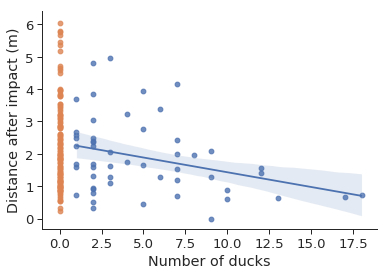

In [10]:
fig, ax = plt.subplots()
no_ducks = idx_data[idx_data['n_landing_strip'] == 0]
ducks = idx_data[idx_data['n_landing_strip'] > 0]

sns.regplot(ducks['n_landing_strip'], ducks['distance_after_impact'], truncate = True)
sns.regplot(no_ducks['n_landing_strip'], no_ducks['distance_after_impact'], fit_reg = False)

x = ducks['n_landing_strip']
y = ducks['distance_after_impact']

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5)) + '\n' + 'n =' + str(len(ducks['n_landing_strip']))

sns.despine()
ax.set_xlabel('Number of ducks')
ax.set_ylabel('Distance after impact (m)')
# plt.show()
# plt.savefig('N_LandingStrip_VS_dist_after_impact',dpi=300)
print(numbers)

In [ ]:
# n_freq = {}
# for i in np.arange(ntrials):
#     r = prox_data_dict[i]['hypot'].copy()
#     xyz = prox_data_dict[i]['trans'].copy()
    
#     theta = idx_data['direction_angle'].iloc[i]
#     gamma = idx_data['skim_arc_angle'].max()
#     theta_min = theta - gamma
#     theta_max = theta + gamma
    
#     x = xyz[:-2,0]
#     n = len(x)
#     points_in_strip = {}
#     n_freq[i] = 0
#     for ii in np.arange(n):
#         phi = np.degrees(np.cos(x[ii]/r[ii]))
#         if r[ii] <= max_dist and phi >= theta_min and phi <= theta_max:
#             points_in_strip[i] = xyz[ii]
#             n_freq[i] += 1
#         else:
#             points_in_strip[i] = np.array([np.nan, np.nan, np.nan])
#             n_freq[i] += 0

# n_landing_strip = [i for i in n_freq.values()]
# idx_data['n_landing_strip'] = n_landing_strip

In [11]:
have_neighbors = idx_data[idx_data['n_landing_strip'] > 0]

In [12]:
to_find = np.array(have_neighbors.index) - 1
nearest = []
for i in to_find:
    r = prox_data_dict[i]['hypot'].copy()
    min_dist = np.min(r)
    nearest.append(min_dist)
have_neighbors['nearest'] = nearest
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [13]:
have_neighbors

,Unnamed: 0,date,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,...,distance_after_impact,impact_speed,impact_angle,mean_angle,direction_angle,end_pos_angle,skim_arc_angle,n_landing_area,n_landing_strip,nearest
2,2,20170228,A01f,1.0,Female,50.0,137.0,137.0,0.0,NaN,...,0.000000,6.883683,15.925344,12.077003,71.944914,0.000000,71.944914,9,9,1.820224
5,5,20170312,C01a,1.0,Female,3.0,20.0,35.0,0.0,NaN,...,1.676704,5.838722,9.526894,10.499120,-12.069050,-7.148831,4.920219,1,1,4.878415
6,6,20170312,C01b,1.0,Male,70.0,115.0,130.0,0.0,NaN,...,1.690916,5.341314,8.708152,11.193392,-2.406291,-1.362384,1.043907,2,2,3.114707
7,7,20170317,A01d,1.0,Male,62.0,103.0,115.0,0.0,NaN,...,0.898127,4.544281,6.963674,15.961054,-57.172530,-59.418748,2.246217,20,2,0.540372
9,9,20170317,A03a,1.0,Male,251.0,293.0,310.0,0.0,NaN,...,0.661698,3.612792,13.757039,18.052380,-22.488546,-25.516517,3.027970,17,17,1.416790
10,10,20170317,A03b,1.0,Male,3.0,51.0,70.0,0.0,NaN,...,1.409659,4.031992,10.979384,2.708204,24.879049,36.732293,11.853244,12,12,1.251799
12,12,20170317,A05b,1.0,Male,275.0,300.0,330.0,0.0,NaN,...,3.046915,6.110434,12.371035,9.315182,48.663129,55.920902,7.257773,2,2,3.393774
13,13,20170317,A06,1.0,Male,25.0,67.0,80.0,0.0,NaN,...,2.476533,8.317471,7.926844,15.065599,-12.335097,15.232873,2.897775,2,2,2.838092
14,14,20170317,A07a,1.0,Female,40.0,91.0,115.0,0.0,NaN,...,2.420134,5.210332,9.148791,8.714208,8.940715,6.548121,2.392594,7,7,1.269615
15,15,20170317,A07b,1.0,Male,51.0,97.0,119.0,0.0,NaN,...,1.967625,5.195994,11.519078,6.930538,13.363810,13.249663,0.114147,8,8,0.802872


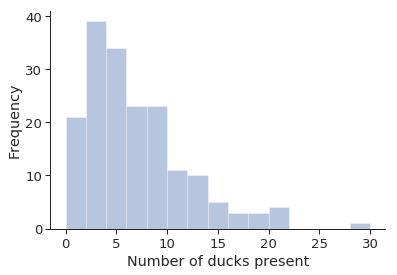

In [14]:
fig, ax = plt.subplots()
sns.distplot(idx_data['n_landing_area'], kde=False, axlabel='Number of ducks present')
sns.despine()
# plt.tight_layout()
ax.set_ylabel('Frequency')
plt.show()
# plt.savefig("N_ducks_LandingArea", dpi=300)

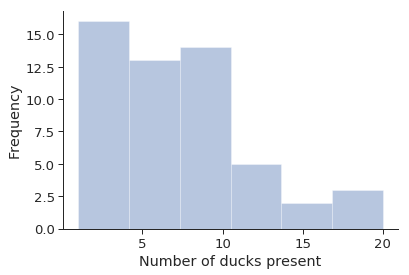

In [15]:
fig, ax = plt.subplots()
sns.distplot(have_neighbors['n_landing_area'], kde=False, axlabel='Number of ducks present')
sns.despine()
# plt.tight_layout()
ax.set_ylabel('Frequency')
plt.show()
# plt.savefig("N_ducks_LandingArea", dpi=300)

r-square = 0.02539
p-value = 0.2544


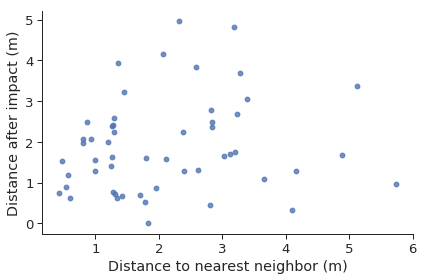

In [23]:
fig, ax = plt.subplots()
sns.regplot(have_neighbors['nearest'], have_neighbors['distance_after_impact'], fit_reg=False)

x = have_neighbors['nearest']
y = have_neighbors['distance_after_impact']

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5))

sns.despine()
ax.set_xlabel('Distance to nearest neighbor (m)')
ax.set_ylabel('Distance after impact (m)')
# plt.show()
plt.tight_layout()
plt.savefig('Nearest_neighbor_VS_dist_after_impact',dpi=300)
print(numbers)

In [ ]:
i=27
p = prox_data_dict[i]['trans'].copy()
x = pd.Series(p[:-2,0])
y = pd.Series(p[:-2,1])

ox = pd.Series(p[-1,0])
oy = pd.Series(p[-1,1])

fig, ax = plt.subplots()
try:
    if idx_data['distance_after_impact'].iloc[i] < 2:
        sns.kdeplot(x,y, color='b', shade=True, shade_lowest=False)
    else:
        sns.kdeplot(x,y, color='g', shade=True, shade_lowest=False)
except:
    pass
sns.scatterplot(x, y, color='g')
sns.scatterplot(ox,oy, color='r', marker='X')
sns.despine()
sns.set_style(style='white')
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
# ax.set_xlim(-max_dist, max_dist)
# ax.set_ylim(-max_dist, max_dist)
ax.set_aspect('equal')
name = 'BivariateKDE_' + str(i+1)
# plt.savefig('Bivariate_limitaxes', dpi=300)
plt.show()